In [1]:
import scipy
import numpy as np
from matplotlib import cm,colors, rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.utils.optical_input import *
from single_photons.utils.metrics import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/simulation/simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
C = ['#2E86C1', '#85C1E9', '#1B4F72']

In [3]:
def custom_optical_input(N, delta_t, photon_number, kappa, cavity_length, detuning, wavelength, duration):
    FSR, f, r, I_factor = compute_cavity_parameters(kappa, cavity_length, detuning, wavelength)
    #I_factor = 1/(1-r)^2
    amplitude = np.sqrt(photon_number * I_factor)
    optical_input = 1j*np.zeros((4,N))
    end = int(duration/delta_t)
    end = min(N,int(N/2) + end)
    s = end - int(N/2)
    optical_input[0,int(N/2):end] = np.array(s*[(np.conjugate(amplitude) + amplitude) * np.sqrt(kappa) * delta_t])
    optical_input[1,int(N/2):end] = np.array(s*[1j*(np.conjugate(amplitude) - amplitude) * np.sqrt(kappa) * delta_t])
    return FSR, f, r, I_factor, optical_input

def custom_SNR(signal,start,duration):
    ref = signal[start - duration:start]
    snr = np.mean(np.power(signal[start:start + duration],2)) / np.mean(np.power(ref,2))
    return snr

def post_process_snr(snr):
    if not np.equal(snr, None).sum():
        mean_pos = np.mean(snr)
        std_pos = np.std(snr)
    else:
        mean_pos = 0
        std_pos = 0
    return mean_pos, std_pos

In [4]:
delta_t = 5e-9
rho = 2200
index_refraction = 1.4440
T = 293
p = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
eta_detection = 0.3 #0.178 = info
control_step = int(32e-9/delta_t) 
fs = 1/(control_step*delta_t)
tweezer_waist = 3.7352e-6#np.sqrt(0.67*0.77)*1e-6 
g_fb_ratio = 50
laser_linewidth = 0
omega = 2*np.pi*104e3
period = 2*np.pi/omega

t = np.arange(0, 300*period, delta_t)
N = t.shape[0]
zp_x = compute_zpx(omega, radius, rho = rho)

In [5]:
cavity_length = 0.030000012000000006
cavity_linewidth = 10*omega
detuning_ratio = 1
gamma, ba_force, std_detection, std_z, g_cs, detuning =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, detuning_ratio, cavity_linewidth, omega,
                                     T = T, rho = rho, index_refraction = index_refraction)
std_detection = std_detection/zp_x
coupling = (1/(4*np.pi))*(ba_force**2)
print(g_cs/omega)

0.13656929397616838


In [63]:
cavity_linewidth

6534512.71946677

In [6]:
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    g_cs,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T,
    g_fb_ratio = g_fb_ratio
)

In [7]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = control_step*delta_t/2*np.array(
    [
        [env.__shot_std__**2, 0, 0, 0],
        [0, env.__shot_std__**2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process]
    ])
R = np.array([[np.power(std_detection, 2)]])
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
#cov_ss = dare(Ad.T, Bd, Q, R)[0]
cov_ss = dare(Ad, Bd, Q, R)[0] #gives better SNR for fidelity than above. why?

In [8]:
sim_sample_bool = 1
kalman_error_bool = 0
detection_measures_bool = 0
SNR_bool = 0

x0 = std_detection
P0 = std_detection**2*np.eye(4)
photon_number = 0
duration = 50e-6
step = 40

FSR, f, r, I_factor, optical_input = custom_optical_input(
    N, delta_t, photon_number, env.__kappa__, cavity_length, detuning, wavelength, duration)

In [9]:
env.G_lqr

array([[ -142097.06826598,   -92989.38006263, 22487333.34207078,
        23730506.93008804]])

In [10]:
if sim_sample_bool or kalman_error_bool:
    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
        env.A,
        env.B, 
        optical_input,
        env.thermal_force_std,
        env.backaction_std,
        env.__shot_std__,
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        np.zeros(env.G_lqr.shape),
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

In [49]:
estimated_states.shape, measured_states.shape

((576924, 4), (576924, 1))

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


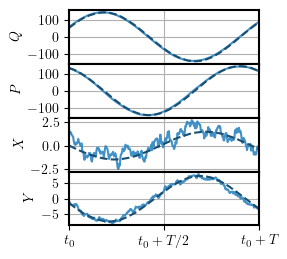

In [62]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)

left = int((N/2 - 0.1*duration/delta_t)/control_step)
right = int((N/2 + 0.1*duration/delta_t)/control_step)


ax1.grid(True, which="both", ls="-")
ax1.set_ylabel(r'$Q$')


ax1.plot(t[::control_step][left:right]*1e3,
            new_states[::control_step, 2][left:right],
            color=C[0], alpha=0.9)
ax1.plot(t[::control_step][left:right]*1e3,
            estimated_states[:,2][::control_step][left:right],
            color = C[2], linestyle='dashed')
ax1.grid(True, which="both", ls="-")



ax2.set_ylabel(r'$P$')
ax2.plot(t[::control_step][left:right]*1e3,
            new_states[::control_step, 3][left:right],
            color=C[0], alpha=0.9)
ax2.plot(t[::control_step][left:right]*1e3,
            estimated_states[:,3][::control_step][left:right],
            color = C[2], linestyle='dashed')
ax2.grid(True, which="both", ls="-")


ax3.set_ylabel(r'$X$')
ax3.plot(t[::control_step][left:right]*1e3,
            new_states[::control_step, 0][left:right],
            color=C[0], alpha=0.9)
ax3.plot(t[::control_step][left:right]*1e3,
            estimated_states[:,0][::control_step][left:right],
            color = C[2], linestyle='dashed')
ax3.grid(True, which="both", ls="-")


ax4.set_ylabel(r'$Y$')
ax4.plot(t[::control_step][left:right]*1e3,
            new_states[::control_step, 1][left:right],
            color=C[0], alpha=0.9)
ax4.plot(t[::control_step][left:right]*1e3,
            estimated_states[:,1][::control_step][left:right],
            color = C[2], linestyle='dashed')
ax4.grid(True, which="both", ls="-")


ax4.set_xlim(t[::control_step][left]*1e3, t[::control_step][right]*1e3)


ax4.set_xticks([t[::control_step][left]*1e3, 1e3*t[::control_step][int(0.5*right+0.5*left)], 1e3*t[::control_step][right]])
ax4.set_xticklabels([r'$t_0$', r'$t_0+T/2$', r'$t_0+T$'])
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [21]:
if kalman_error_bool:
    size = int(N/control_step)
    signal = np.zeros(size)
    for i in range(size):
        signal[i] = zp_x/1e-9*(measured_states[::control_step][i] - estimated_states[::control_step,2][i]).real
    opt_pulse = abs(optical_input[0,:])
    opt_pulse = 0.8*max(signal)*opt_pulse/max(opt_pulse)

In [22]:
if kalman_error_bool:
    '''List of parameters used in last run:
    delta_t = 5e-9
    rho = 2200
    index_refraction = 1.4440
    T = 293
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    eta_detection = 0.3
    control_step = int(32e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    tweezer_waist = 3.7352e-6
    g_fb_ratio = 50
    laser_linewidth = 0
    omega = 2*np.pi*104e3
    t = np.arange(0, 3000*period, delta_t)
    cavity_length = 0.03/1.001
    cavity_linewidth = 10*omega
    detuning_ratio = 1
    photon_number = 25
    duration = 5e-5'''
    factor = 0.93
    fig,ax = plt.subplots()
    plt.rcParams.update({'font.size':10})
    plt.rcParams['axes.linewidth'] = 1.5
    fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
    plt.grid(alpha = 0.3)
    
    left = int((N/2 - 2*duration/delta_t)/control_step)
    right = int((N/2 + 3*duration/delta_t)/control_step)
    
    plt.plot(1e3*t[::control_step][:signal.shape[0]], signal,
             color = C[2], alpha = 0.7, linewidth = 0.15)
    '''plt.plot(1e3*t[::control_step], opt_pulse[::control_step], linestyle = '--',
             color = 'red', alpha = 0.5, linewidth = 0.7)'''
    plt.xlabel(r'$t$ (ms)')
    plt.ylabel(r'$\delta_K$ (nm)', labelpad = 0)
    #plt.xlim([1e3*left*control_step*delta_t, 1e3*right*control_step*delta_t])
    plt.xlim([14.35, 14.55])
    plt.xticks(np.array([14.35, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 14.55]),
               labels = ['14.35', r'$t_{start}$', '$t_{end}$', '14.55'])
    plt.ylim([-0.55, 0.55])
    labels = []
    '''for tick in ax.get_yticks():
        label = f'{tick:.1f}'
        labels.append(label.rstrip('.'))
    ax.set_yticklabels(labels)'''
    plt.savefig('kalman_error.pdf', bbox_inches = 'tight')
    plt.show()

In [23]:
if detection_measures_bool:
    data = []
    numbers = np.array([0.5, 9, 80])
    
    for photon_number in tqdm(numbers):
        if 'optical_input' in globals():
            del optical_input
        if 'new_states' in globals():
            del new_states, measured_states, estimated_states, cov_aposteriori, controls
        FSR, f, r, I_factor, optical_input = custom_optical_input(
            N, delta_t, photon_number, env.__kappa__, cavity_length, detuning, wavelength, duration)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std,
            env.__shot_std__,
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            env.G_lqr,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        
        X = estimated_states[:,0][::control_step].real
        Y = estimated_states[:,1][::control_step].real
        pos = estimated_states[:,2][::control_step].real
        P = estimated_states[:,3][::control_step].real
        phonons = compute_phonons(estimated_states, cov_aposteriori, control_step, step = step)
        fidelity = compute_fidelity(estimated_states, cov_aposteriori, cov_ss, control_step, step=step)
        
        data.append([X, Y, pos, P, phonons, fidelity])
        del X, Y, pos, P, phonons, fidelity
    data = np.array(data)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [08:44<00:00, 174.72s/it]
C:\Users\jorge\AppData\Local\Temp\ipykernel_5812\1707921316.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


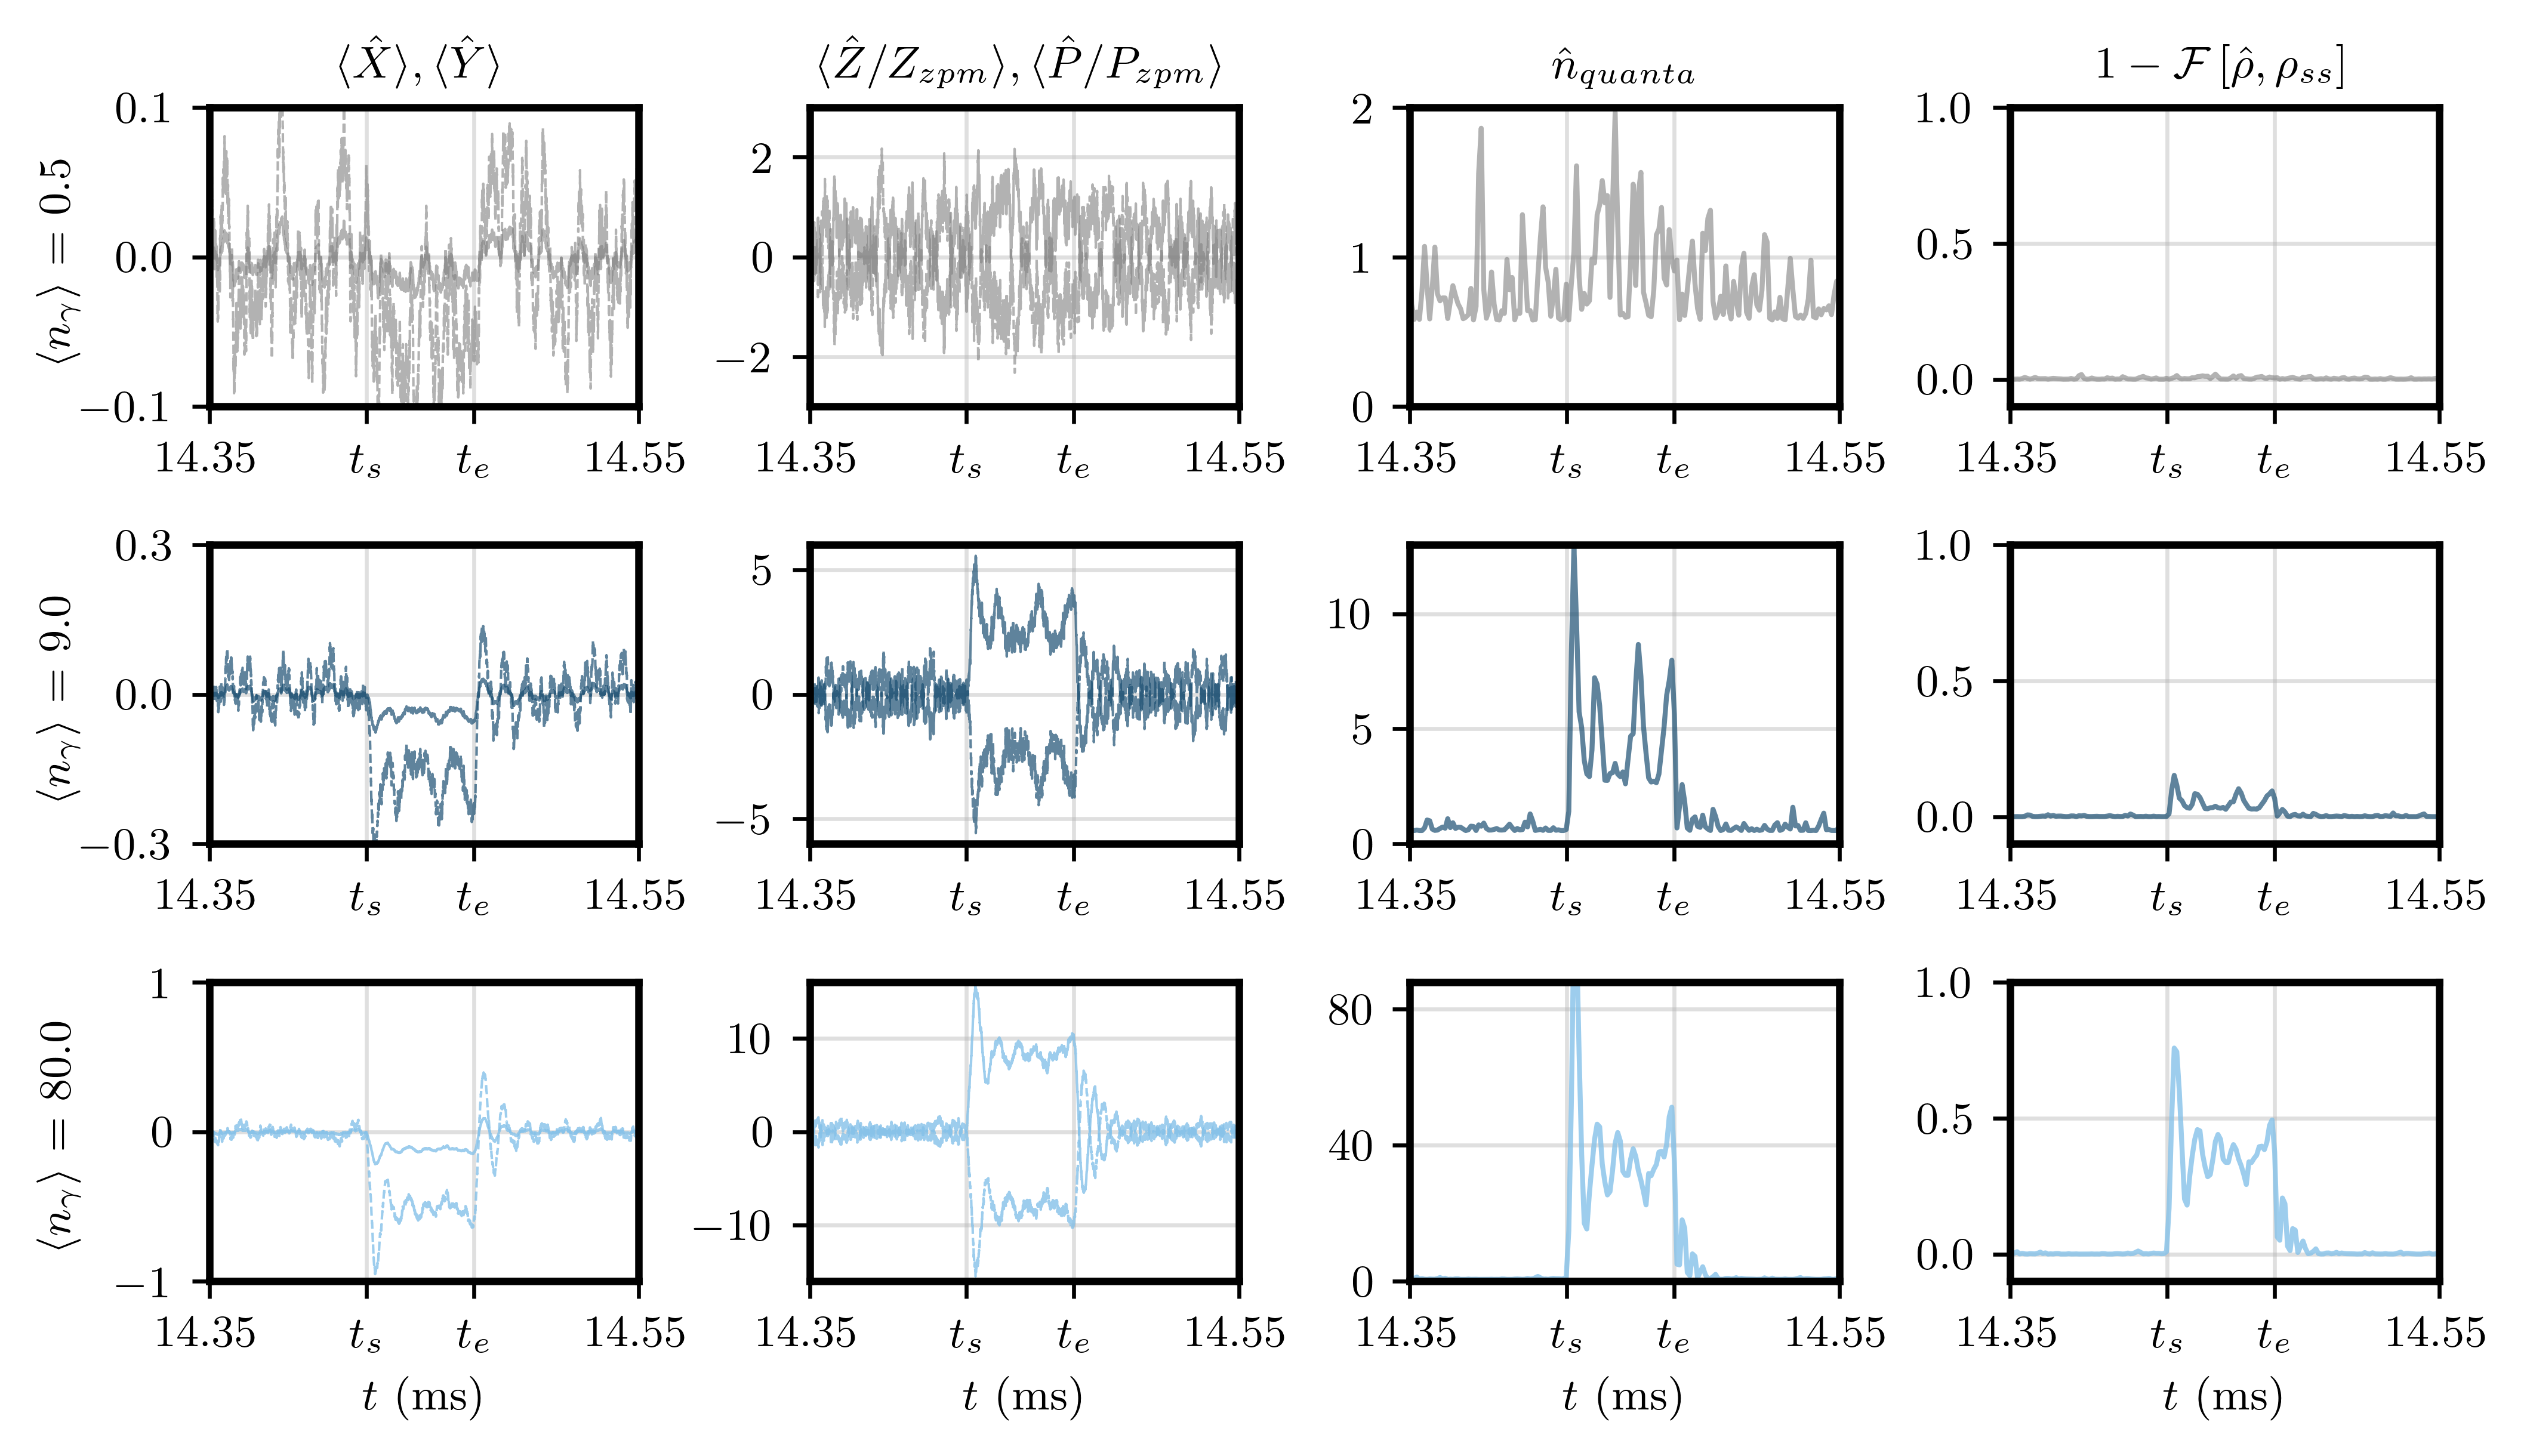

In [24]:
if detection_measures_bool:
    '''List of parameters used in last run:
    delta_t = 5e-9
    rho = 2200
    index_refraction = 1.4440
    T = 293
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    eta_detection = 0.3
    control_step = int(32e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    tweezer_waist = 3.7352e-6
    g_fb_ratio = 50
    laser_linewidth = 0
    omega = 2*np.pi*104e3
    t = np.arange(0, 3000*period, delta_t)
    cavity_length = 0.03/1.001
    cavity_linewidth = 10*omega
    detuning_ratio = 1
    photon_number = 25
    duration = 5e-5
    step = 40
    start = int(25e-6/(delta_t*control_step*step))
    numbers = np.array([0.5, 9, 80])
    '''
    factor = 0.76
    nrow = 3
    ncol = 4
    fig, ax =\
        plt.subplots(nrow, ncol, figsize = (factor*9,factor*5))
    plt.rcParams.update({'font.size':9})
    plt.rcParams['axes.linewidth'] = 0.1
    plt.tight_layout()

    inf_xlim = 14.35#1e3*N/2*delta_t - 2e3*duration
    sup_xlim = 14.55#1e3*N/2*delta_t + 3e3*duration
    
    n_colors = ['gray', C[2], C[1]]
    for i in range(nrow):
        alpha = 0.6 + i/10
        color = n_colors[i]
        for j in range(ncol):
            if j < 2:
                lw = 0.5
            else:
                lw = 1.0
                
            if j < 2:
                ax[i,j].plot(1e3*t[::control_step], data[i, 2*j], alpha = alpha, color = color, linewidth = lw, linestyle = 'solid')
                ax[i,j].plot(1e3*t[::control_step], data[i, 2*j+1], alpha = alpha, color = color, linewidth = lw, linestyle = 'dashed')
            elif j == 2:
                ax[i,j].plot(1e3*t[::control_step*step][:data[i, j+2].shape[0]],
                             data[i, j+2], alpha = alpha, color = color, linewidth = lw)
            else:
                ax[i,j].plot(1e3*t[::control_step*step][:data[i, j+2].shape[0]],
                             1-data[i, j+2]/max(data[i, j+2][30:]), alpha = alpha, color = color, linewidth = lw)
            ax[i,j].set_xlim([inf_xlim, sup_xlim])
            if j == 0:
                ax[0,j].set_ylim([-0.1, 0.1])
                ax[0,j].set_yticks(np.arange(-0.1,0.11,step = 0.1))
                ax[1,j].set_ylim([-0.3, 0.3])
                ax[1,j].set_yticks(np.arange(-0.3,0.31,step = 0.3))
                ax[2,j].set_ylim([-1,1])
                ax[2,j].set_yticks(np.arange(-1,1.1))
            if j == 1:
                ax[0,j].set_ylim([-3,3])
                ax[1,j].set_ylim([-6,6])
                ax[2,j].set_ylim([-16,16])
            if j == 2:
                ax[i,j].set_ylim([0,2 - 21*i + 32*i**2])
            if j == 3:
                ax[i,j].set_ylim([-0.1,1])
            ax[i,j].set_xticks(np.array([14.35, 1e3*(N/2*delta_t), 1e3*(N/2*delta_t + duration), 14.55]),
                               labels = ['14.35', r'$t_{s}$', '$t_{e}$', '14.55'])
            ax[i,j].grid(alpha=0.4)
            if i == 2:
                ax[i,j].set_xlabel(r'$t$ (ms)', fontsize = plt.rcParams['font.size'])
                '''ax[i,j].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))'''
    ax[0,0].set_title(r'$\langle \hat{X} \rangle, \langle \hat{Y} \rangle$', fontsize = plt.rcParams['font.size'])
    ax[0,1].set_title(r'$\langle \hat{Z}/Z_{zpm} \rangle, \langle \hat{P}/P_{zpm} \rangle$', fontsize = plt.rcParams['font.size'])
    ax[0,2].set_title(r'$\hat{n}_{quanta}$', fontsize = plt.rcParams['font.size'])
    ax[0,3].set_title(r'$1-\mathcal{F} \left[ \hat{\rho}, \rho_{ss} \right]$', fontsize = plt.rcParams['font.size'])
    ax[0,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[0]), labelpad = 0, fontsize = plt.rcParams['font.size'])
    ax[1,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[1]), labelpad = 0, fontsize = plt.rcParams['font.size'])
    ax[2,0].set_ylabel(r'$\langle n_\gamma \rangle$ =' + ' {}'.format(numbers[2]), labelpad = 7, fontsize = plt.rcParams['font.size'])
    ax[2,2].set_yticks(np.arange(0,81,step=40))
        
    #plt.savefig('detection_measures.pdf', bbox_inches = 'tight')
    #plt.show()

In [25]:
if SNR_bool:
    data = []
    numbers = np.power(np.linspace(1,10,28),2)
    left = N/2 - duration/delta_t
    right = N/2 + duration/delta_t

    for photon_number in tqdm(numbers):
        if 'optical_input' in globals():
            del optical_input
        if 'new_states' in globals():
            del new_states, measured_states, estimated_states, cov_aposteriori, controls
        FSR, f, r, I_factor, optical_input = custom_optical_input(
            N, delta_t, photon_number, env.__kappa__, cavity_length, detuning, wavelength, duration)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std,
            env.__shot_std__,
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            env.G_lqr,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        
        sample = estimated_states[int(left):int(right),:].real
        cov_sample = cov_aposteriori[int(left/control_step):int(right/control_step),:,:]
        pos = sample[:,2].real
        phonons = compute_phonons(sample, cov_sample, control_step, step = step)
        fidelity = 1 - compute_fidelity(sample, cov_sample, cov_ss, control_step, step=step)
        
        SNR_pos = custom_SNR(pos,int(duration/delta_t),int(duration/delta_t))
        SNR_phn = custom_SNR(phonons,int(duration/(step*control_step*delta_t)),int(duration/(step*control_step*delta_t)))
        SNR_fid = custom_SNR(fidelity,int(duration/(step*control_step*delta_t)),int(duration/(step*control_step*delta_t)))
        
        data.append([SNR_pos, SNR_phn, SNR_fid])
    data = np.array(data)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [15:32<00:00, 33.29s/it]


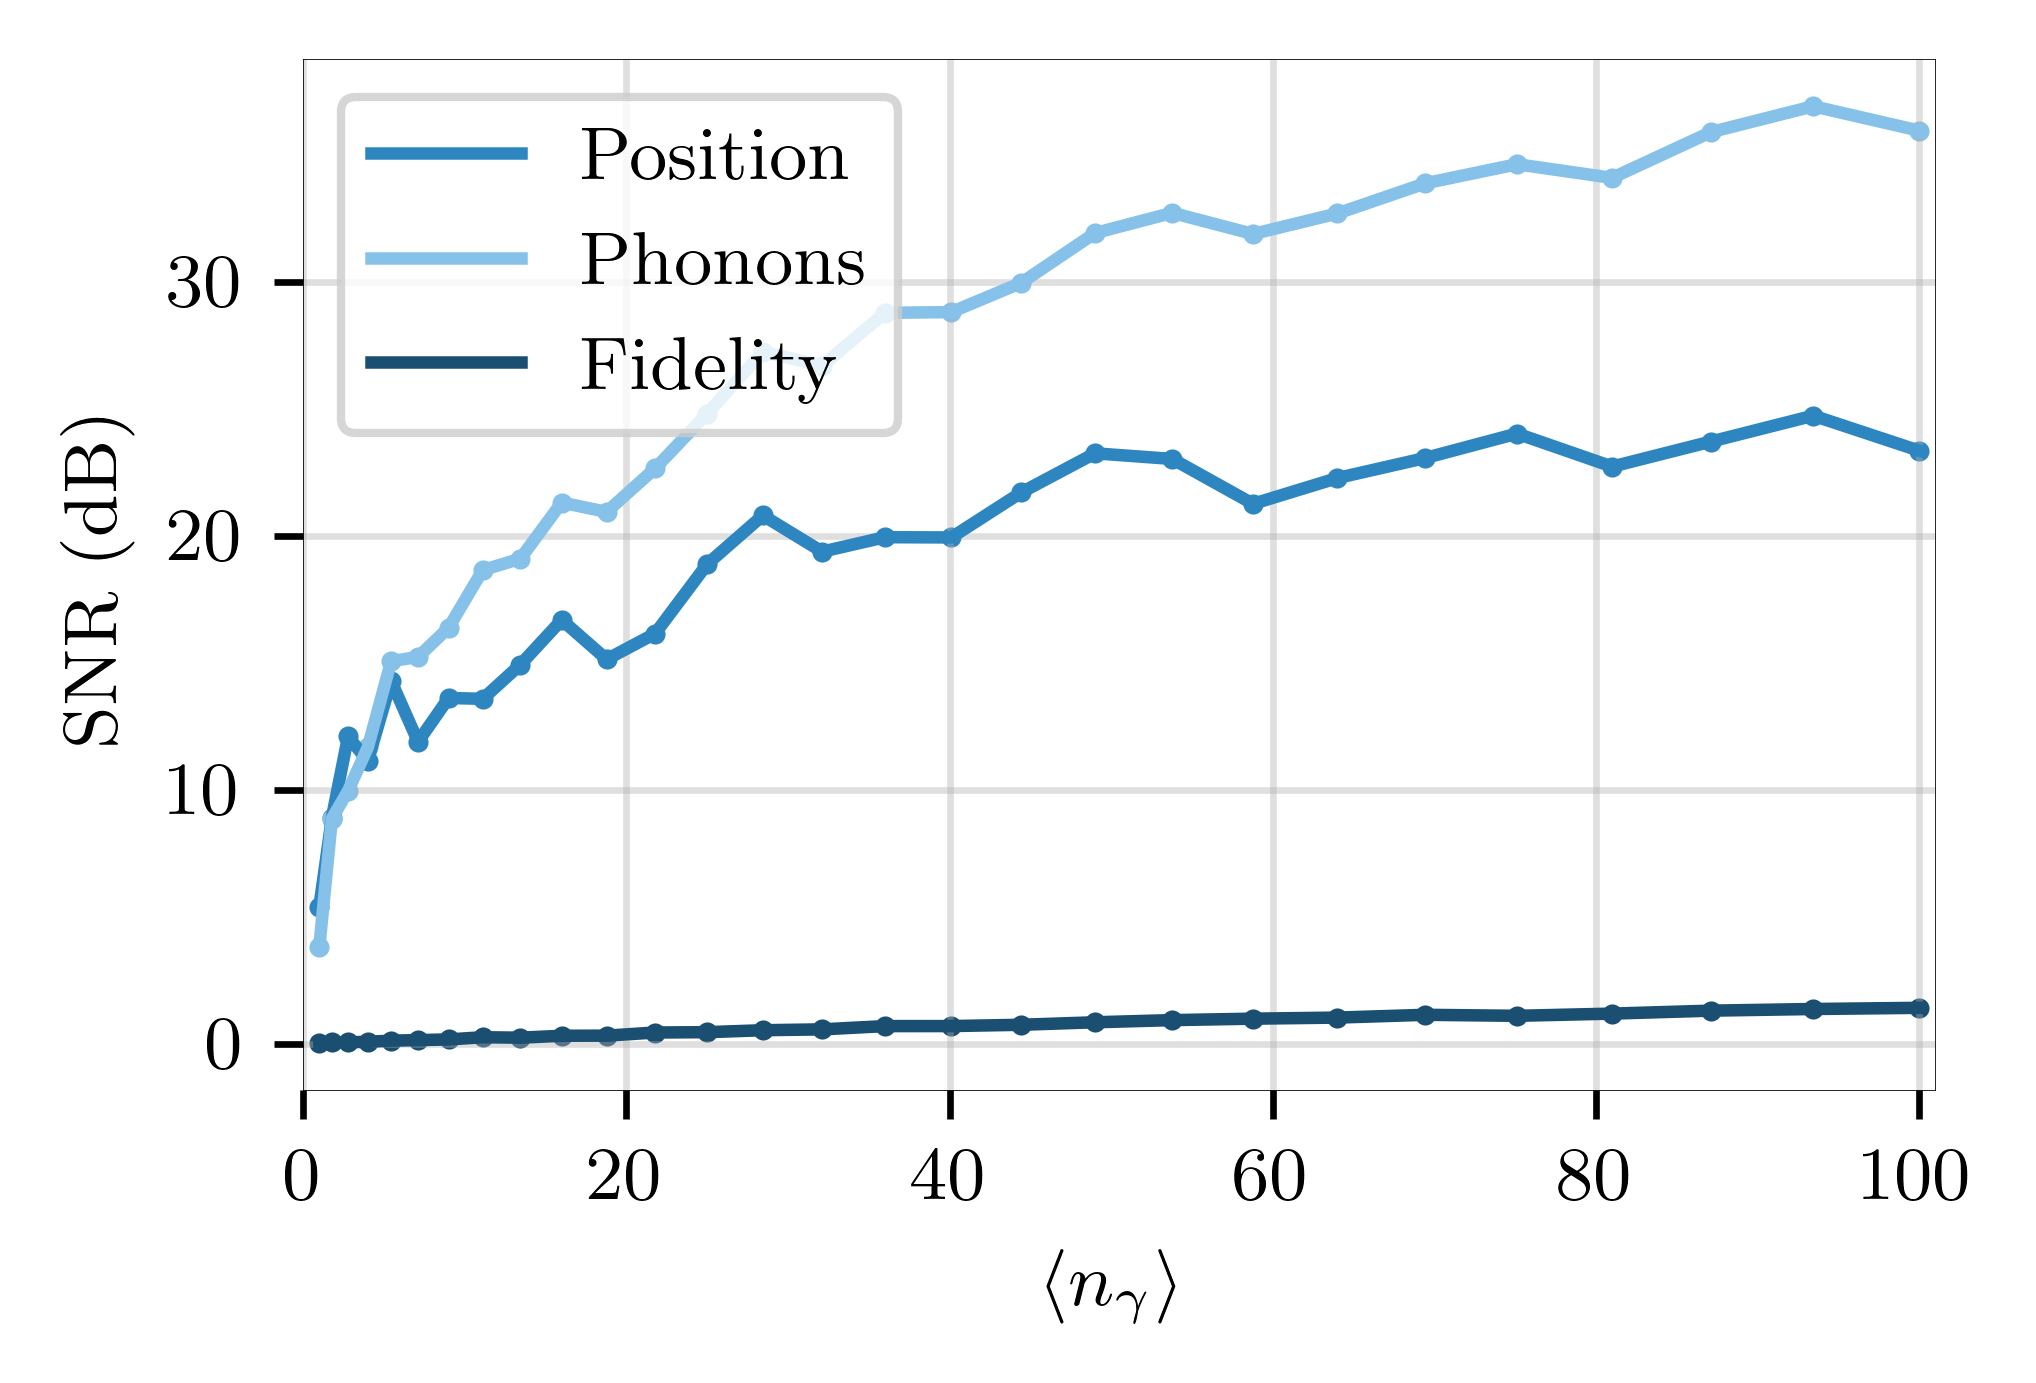

In [26]:
if SNR_bool:
    '''Parameters used in the last run:
    delta_t = 5e-10
    rho = 2200
    index_refraction = 1.4440
    T = 293
    p = 1e-6
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 400e-3
    eta_detection = 0.178#0.178
    control_step = int(30e-9/delta_t) 
    fs = 1/(control_step*delta_t)
    cavity_waist = 10e-6 #only affects theoretical opmech coupling
    cavity_length = 0.03
    tweezer_waist = 0.6e-6
    detuning_ratio = 0.25 
    cavity_linewidth_ratio = 0.38
    optomechanical_coupling_ratio = 0.19
    g_fb_ratio = 5
    laser_linewidth = 0
    numbers = np.power(np.linspace(1,12,40),2)
    step = 40
    '''
    labels = ['Position', 'Phonons', 'Fidelity']
    factor = 0.99
    fig,ax = plt.subplots()
    plt.rcParams.update({'font.size':9})
    plt.rcParams['axes.linewidth'] = 1.5
    fig.set_size_inches(3.5*factor, 2.4*factor, forward = True)
    plt.grid(alpha = 0.4)
    
    M = 0
    for i in range(3):
        y = np.array(data.shape[0]*[None])
        x = np.array(data.shape[0]*[None])
        for j in range(data.shape[0]):
            non_null_y = []
            if np.isnan(data[j,i]):
                continue
            else:
                x[j] = numbers[j]
                y[j] = 10*np.log10(data[j,i])
                non_null_y.append(10*np.log10(data[j,i]))
            if max(non_null_y) > M:
                M = max(non_null_y)
        ax.plot(x, y, color = C[i], label = labels[i])
        ax.scatter(x, y, color = C[i], s = 2)
    ymin = -0.1*M
    ymax = 1.1*M
    xmin = 0
    xmax = numbers[-1] + numbers[0]
    ax.set_xlim([xmin, xmax])
    #ax.fill_between(np.array([xmin, xmax]), np.array(2*[ymin]), np.array(2*[20]), color = 'gray', alpha = 0.3)
    plt.ylabel(r'SNR (dB)', fontsize = plt.rcParams['font.size'])
    plt.xlabel(r'$\langle n_\gamma \rangle$', fontsize = plt.rcParams['font.size'])
    plt.legend(loc = 'upper left', fontsize = plt.rcParams['font.size'])
    plt.tight_layout()
    #plt.savefig('SNR_measures.pdf',bbox_inches = 'tight',dpi = 600)
    plt.show()

In [11]:
left = N/2 - duration/delta_t
right = N/2 + duration/delta_t
sample = estimated_states[int(left):int(right),:].real
cov_sample = cov_aposteriori[int(left/control_step):int(right/control_step),:,:]

cov_ss_1 = dare(Ad.T, Bd, Q, R)[0]
cov_ss_2 = dare(Ad,Bd,Q,R)[0]
fidelity_1 = compute_fidelity(sample,cov_sample, cov_ss_1, control_step, step=step)
fidelity_2 = compute_fidelity(sample,cov_sample, cov_ss_2, control_step, step=step)

In [13]:
SNR_1 = custom_SNR(fidelity_1,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
SNR_2 = custom_SNR(fidelity_2,int(duration/(control_step*step*delta_t)),int(duration/(control_step*step*delta_t)))
print(SNR_1,SNR_2)

(0.7855607100516124-3.3029387319853142e-18j) (0.42937232633237404-1.1938535178496646e-19j)


In [65]:
lengths = np.linspace(-0.0000001103,-0.00000011025,1000)
detuning = 0
lengths = 0.03/(1+lengths)
I_facs = np.zeros(lengths.shape[0])
for i in range(lengths.shape[0]):
    FSR, f, r, I_factor = compute_cavity_parameters(env.__kappa__, lengths[i], detuning, wavelength)
    I_facs[i] = I_factor

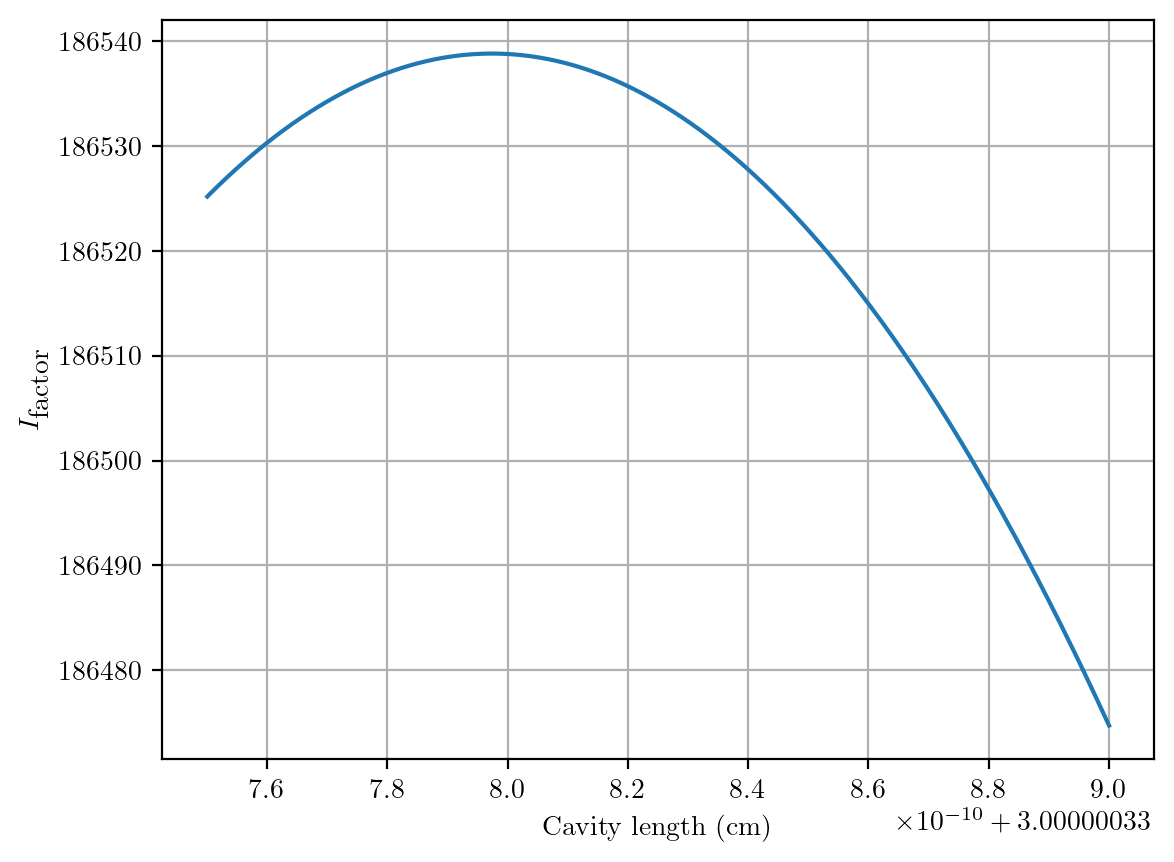

In [66]:
plt.plot(lengths/1e-2,I_facs)
plt.grid()
plt.ylabel(r'$I_\textrm{factor}$')
plt.xlabel('Cavity length (cm)')
plt.show()

In [18]:
print(I_facs)

[184862.84896954 184862.84896954 184862.84896954 ... 184865.20239924
 184865.20239924 184865.20239924]
